# CHI-T: Reanalysis (RUC)

### Categorical Hazard Index for Tornadoes / Cameron Hype Index for Tornadoes
Setup: do not touch

In [ ]:
def CHI_hourly_RUC(year, month, day, hour, fcst, center_lat, center_lon, domain):
                 
    # Imports software
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.feature import ShapelyFeature
    from cartopy.io.shapereader import Reader
    import scipy.ndimage as ndimage
    from datetime import datetime, timedelta
    from netCDF4 import num2date
    from siphon.catalog import TDSCatalog
    from siphon import ncss
    from siphon.ncss import NCSS
    import metpy.calc as mpcalc
    from metpy.units import units
    from metpy.plots import ctables
    from CHI import CHI

    # Form Domain
    if domain == 'local':
        north_lat = center_lat + 2.2
        south_lat = center_lat - 2.2
        west_lon = center_lon - 3.4
        east_lon = center_lon + 3.4
    elif domain == 'state':
        north_lat = center_lat + 3.0
        south_lat = center_lat - 3.0
        west_lon = center_lon - 4.65
        east_lon = center_lon + 4.65
    elif domain == 'sub-regional':
        north_lat = center_lat + 3.8
        south_lat = center_lat - 3.8
        west_lon = center_lon - 5.9
        east_lon = center_lon + 5.9
    elif domain == 'regional':
        north_lat = center_lat + 5.21
        south_lat = center_lat - 5.21
        west_lon = center_lon - 8.1
        east_lon = center_lon + 8.1
    elif domain == 'super-regional': 
        north_lat = center_lat + 7.7
        south_lat = center_lat - 7.7
        west_lon = center_lon - 12
        east_lon = center_lon + 12
    else:
        north_lat = center_lat + 7.7
        south_lat = center_lat - 7.7
        west_lon = center_lon - 12
        east_lon = center_lon + 12
    #Default center: 38.0, -94.0
    
    # Shapefilepath
    shapefilepath = '/home/cameron/Documents/Python/Shapefiles/'
        
    # Downloads RUC data
    data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/ruc130anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
    # Initiates query
    query = data.query()
    # Subsets by data
    query.variables('MSLP_MAPS_System_Reduction_msl',
                    'Pressure_surface',
                    'Geopotential_height_isobaric',
                    'Temperature_isobaric',
                    'Relative_humidity_isobaric',
                    'Temperature_height_above_ground',
                    'Dewpoint_temperature_height_above_ground',
                    'Pseudo-adiabatic_potential_temperature_or_equivalent_potential_temperature_surface', 
                    'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                    'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                    'U-Component_Storm_Motion_surface', 
                    'V-Component_Storm_Motion_surface', 
                    'Convective_available_potential_energy_surface',
                    'Convective_inhibition_surface', 
                    'Geopotential_height_equilibrium',
                    'Storm_relative_helicity_height_above_ground_layer',
                    'Composite_reflectivity_entire_atmosphere_single_layer',#_single_layer
                    ).add_lonlat()
    # Subsets by area
    query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
    # Gets data
    data_RUC = data.get_data(query)

    # Defines RUC data
    mslp   = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
    mslps  = data_RUC.variables['Pressure_surface'][0,:,:]/100
    hght   = data_RUC.variables['Geopotential_height_isobaric'][0,:,:,:]
    tmpp   = data_RUC.variables['Temperature_isobaric'][0,:,:,:]
    relh   = data_RUC.variables['Relative_humidity_isobaric'][0,:,:,:]
    tmps   = data_RUC.variables['Temperature_height_above_ground'][0,0,:,:]
    dwps   = data_RUC.variables['Dewpoint_temperature_height_above_ground'][0,0,:,:]
    thetae = data_RUC.variables['Pseudo-adiabatic_potential_temperature_or_equivalent_potential_temperature_surface'][0,:,:]
    uwnd   = data_RUC.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
    vwnd   = data_RUC.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
    uwndp  = data_RUC.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
    vwndp  = data_RUC.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
    uwndsm = data_RUC.variables['U-Component_Storm_Motion_surface'][0,:,:]*1.94384
    vwndsm = data_RUC.variables['V-Component_Storm_Motion_surface'][0,:,:]*1.94384
    cape   = data_RUC.variables['Convective_available_potential_energy_surface'][0,:,:]
    cinh   = data_RUC.variables['Convective_inhibition_surface'][0,:,:]
    eqlh   = data_RUC.variables['Geopotential_height_equilibrium'][0,:,:]
    srh1   = data_RUC.variables['Storm_relative_helicity_height_above_ground_layer'][0,0,:,:]
    radr   = data_RUC.variables['Composite_reflectivity_entire_atmosphere_single_layer'][0,:,:]#_single_layer
    
    # Gets name of dimension
    dtime = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
    dlat = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
    dlon = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
    # Gets dimension data
    lat = 1000*(data_RUC.variables[dlat][:])
    lon = 1000*(data_RUC.variables[dlon][:])
    time = data_RUC.variables[dtime]
    
    # Gets number of latitude/longitude points
    latnum = lat.shape[0]
    lonnum = lon.shape[0]
    # Set up times
    vtimes = num2date(time[:],time.units)
    
    data_RUC.close()

    # Finds 2km Temp for 0-2km Lapse Rate
    p = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000] * units.hPa
    p = p[::-1]
    T = tmpp[::-1]*units.degC
    h = hght[::-1,:,:]*units.meter
    bottom = mslps[:,:]*units.hPa
    depth = 2000*units.meter

    def temp_layer(pressure,temp,heights,bottom,layer):
        p2,t2 = mpcalc.get_layer(pressure, temp, height=heights, bottom=bottom, depth=layer)
        return t2[-1]

    def temp_layer_fail(pressure,temp,heights,layer):
        p2,t2 = mpcalc.get_layer(pressure, temp, height=heights, depth=layer)
        return t2[-1]

    tmpc2 = np.full((lat.shape[0],lon.shape[0]), np.nan)
    for i in range(lat.shape[0]):
        for j in range(lon.shape[0]):
            if (mslps[i,j]>=1000):
                tmpc2[i,j] = temp_layer_fail(p[:],T[:,i,j].m,h[:,i,j].m,depth)
            else:
                tmpc2[i,j] = temp_layer(p[:],T[:,i,j].m,h[:,i,j].m,bottom[i,j],depth)

    # Performs variety of calculations

    # Converts temperature to Celsius
    tmppc = tmpp - 273.15
    # Calculates sfc-2km Lapse Rate
    lrlow = ((tmps[:,:] - tmpc2[:,:]) / 2000)*1000
    # Calculates 700-500mb Lapse Rate
    lrmid = ((tmpp[24,:,:] - tmpp[16,:,:]) / (hght[16,:,:] - hght[24,:,:]))*1000

    # Calculates Storm Relative Winds
    uwndsr = np.array(uwnd[:,:] - uwndsm[:,:])
    vwndsr = np.array(vwnd[:,:] - vwndsm[:,:])
    uwndpsr = uwndp[:,:] - uwndsm[:,:]
    vwndpsr = vwndp[:,:] - vwndsm[:,:]
    spedsr = np.sqrt(uwndsr**2+vwndsr**2)
    spedpsr = np.sqrt(uwndpsr**2+vwndpsr**2)
    # Calculates Mean Storm Relative Wind (Sfc+925+850+775+700+600+500+400+300)
    spedpsrmean = (spedsr + spedpsr[33,:,:] + spedpsr[30,:,:] + spedpsr[27,:,:] + spedpsr[24,:,:] + spedpsr[20,:,:] + spedpsr[16,:,:] + spedpsr[12,:,:] + spedpsr[8,:,:]) / 9

    # Calculates direction of sfc Storm Relative Winds
    wndsrdir = get_wind_dir(uwndsr,vwndsr)
    # Calculates Surface Vorticity
    dusy = np.array(np.gradient(uwnd[:,:]/1.94384))[0,:,:]
    dvsx = np.array(np.gradient(vwnd[:,:]/1.94384))[1,:,:]
    vorts = ((dvsx/13000) - (dusy/13000))*100000
    # Calculates theta-e gradients
    thetae1 = thetae
    dtx1 = np.array(np.gradient(thetae1[:,:]))[1,:,:]
    dty1 = np.array(np.gradient(thetae1[:,:]))[0,:,:]
    thetaegrad1 = np.sqrt(((dtx1/13000)**2+(dty1/13000)**2))*100000
    thetagradangle1 = (np.pi/2) - np.arctan2(dty1, dtx1)
    # Calculates storm relative inflow relative to theta-e boundary
    boundaryangle = thetagradangle1 - (np.pi/2)
    srinflowangle = wndsrdir
    inflowboundaryangle = np.abs(np.cos(np.radians(boundaryangle - srinflowangle)))
    srvort = ndimage.gaussian_filter((inflowboundaryangle*vorts), sigma=1)

    # Calculates LFC
    p = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000] * units.hPa
    p = p[::-1]
    h = hght[::-1,:,:]*units.meter
    T = tmppc*units.degC
    T = T[::-1,:,:]
    #Td = mpcalc.dewpoint_rh(T, (relh[::-1,:,:]/100))
    Td = (243.04*(np.log(relh/100)+((17.625*tmppc)/(243.04+tmppc)))/(17.625-np.log(relh/100)-((17.625*tmppc)/(243.04+tmppc))))*units.degC
    Td = Td[::-1,:,:]

    lfcs = np.full((lat.shape[0],lon.shape[0]), np.nan)
    for i in range(lat.shape[0]):
        for j in range(lon.shape[0]):
            try:
                lfcs[i,j] = mpcalc.lfc(p[:],T[:,i,j],Td[:,i,j])[0].m
            except IndexError:
                lfcs[i,j] = 0.0
                pass
            except RuntimeError:
                lfcs[i,j] = 0.0
                pass
    lfcs = lfcs * units.hectopascal
    lfcsh = np.full((lat.shape[0],lon.shape[0]),np.nan)
    for i in range(lat.shape[0]):
        for j in range(lon.shape[0]):
            lfcsh = mpcalc.pressure_to_height_std(lfcs)
    lfcs = (lfcsh*1000)
    lfcs = lfcs.m
    lfcs[np.isnan(lfcs)] = 0
    lfcs = ndimage.gaussian_filter(lfcs[:,:], sigma=1)

    # Calculates LCL
    lcls = np.full((lat.shape[0],lon.shape[0]), np.nan)
    for i in range(lat.shape[0]):
        for j in range(lon.shape[0]):
            try:
                lcls[i,j] = mpcalc.lcl(mslp[i,j]*units.hPa,tmps[i,j]*units.degC,dwps[i,j]*units.degC)[0].m
            except IndexError:
                lcls[i,j] = 0.0
                pass
            except RuntimeError:
                lcls[i,j] = 0.0
                pass
    lcls = lcls * units.hectopascal
    lclsh = np.full((lat.shape[0],lon.shape[0]),np.nan)
    for i in range(lat.shape[0]):
        for j in range(lon.shape[0]):
            lclsh = mpcalc.pressure_to_height_std(lcls)
    lcls = (lclsh*1000)
    lcls = lcls.m
    lcls[np.isnan(lcls)] = 0
    lcls = ndimage.gaussian_filter(lcls[:,:], sigma=1)

    # Calculates Normalized CAPE
    eqlh = ndimage.gaussian_filter(eqlh[:,:], sigma=1)
    ncape = cape / (eqlh-lfcs)

    # Calculates 0-3km CAPE
    p = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000] * units.hPa
    p = p[::-1]
    h = hght[::-1,:,:]*units.meter
    T = tmppc*units.degC
    T = T[::-1,:,:]
    #Td = mpcalc.dewpoint_rh(T, (relh[::-1,:,:]/100))
    Td = (243.04*(np.log(relh/100)+((17.625*tmppc)/(243.04+tmppc)))/(17.625-np.log(relh/100)-((17.625*tmppc)/(243.04+tmppc))))*units.degC
    Td = Td[::-1,:,:]
    depth = 3000*units.meter

    def cape_layer(pressure,temperature,dewpt,heights,layer):
        p3, T3, Td3 = mpcalc.get_layer(pressure, temperature, dewpt, height=heights, depth=layer)

        cape_layer,cin_layer = mpcalc.most_unstable_cape_cin(p3,T3,Td3)
        return cape_layer,cin_layer

    threecape = np.full((lat.shape[0],lon.shape[0]), np.nan)
    for i in range(lat.shape[0]):
        for j in range(lon.shape[0]):
            try:
                threecape[i,j] = cape_layer(p[:],T[:,i,j],Td[:,i,j],h[:,i,j],depth)[0].m
            except IndexError:
                threecape[i,j] = 0.0
                pass
            except RuntimeError:
                threecape[i,j] = 0.0
                pass
    threecape = threecape * units('J/kg')

    # Set up our projection
    crs = ccrs.PlateCarree()
    globe = ccrs.Globe(datum='WGS84',ellipse='sphere')

    # Set up our array of latitude and longitude values and transform to 
    # the desired projection. (RUC)
    clons, clats = np.meshgrid(lon, lat)
    tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-95, central_latitude=25,standard_parallels=(25.,25.),globe=globe),clons,clats)
    tlons = tlatlons[:,:,0]
    tlats = tlatlons[:,:,1]

    # Limit the extent of the map area, must convert to proper coords.
    LL = crs.transform_point((west_lon + 0.5),(north_lat - 0.34),ccrs.PlateCarree())
    UR = crs.transform_point((east_lon - 0.5),(south_lat + 0.34),ccrs.PlateCarree())

    # Get data to plot state and province boundaries
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lakes',
            scale='10m',
            facecolor='none')
    counties = str(shapefilepath)+'cb_2016_us_county_20m'
    shape_feature = ShapelyFeature(Reader(counties).geometries(), ccrs.PlateCarree())
    roads = str(shapefilepath)+'tl_2016_us_primaryroads'
    shape_feature1 = ShapelyFeature(Reader(roads).geometries(), ccrs.PlateCarree())
    roads2 = str(shapefilepath)+'ne_10m_roads'
    shape_feature2 = ShapelyFeature(Reader(roads2).geometries(), ccrs.PlateCarree())
        
    chi = CHI(threecape[:,:],ncape[:,:],cape[:,:],lrlow[:,:],lrmid[:,:],lcls[:,:],srh1[:,:],srvort[:,:],spedpsrmean[:,:],cinh[:,:],eqlh[:,:],latnum,lonnum)
    chi = ndimage.gaussian_filter(chi, sigma=0.5)

    %matplotlib inline

    fig=plt.figure(1,figsize=(12,8.25))
    ax = plt.subplot(111,projection=crs)
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
    
    ax.add_feature(states_provinces,edgecolor='black',linewidth=1.0, zorder=2)
    ax.add_feature(shape_feature, facecolor='none', edgecolor='lightgray', linewidth=.75, zorder=1)
    ax.add_feature(shape_feature2, facecolor='none', edgecolor='royalblue', linewidth=.5, zorder=1)
    ax.add_feature(shape_feature1, facecolor='none', edgecolor='royalblue', linewidth=.75, zorder=1)
    
    # Plot CHI
    cs2 = ax.contour(tlons,tlats,chi,[0.33,1,2,3,4,5],colors=['deepskyblue','darkgreen','yellow','darkorange','red','magenta'],linewidths=2.5,linestyles=['dashed','solid','solid','solid','solid','solid'])
    ax.clabel(cs2, fontsize=13, inline=1, inline_spacing=2, fmt='%i', rightside_up=True, use_clabeltext=False)
    try:
        chifrange = np.arange(0.3333333,1,0.6666666)
        cf2 = ax.contourf(tlons,tlats,chi,chifrange,colors='deepskyblue',alpha=0.2)
        cf3 = ax.contourf(tlons,tlats,chi,range(1,3,1),colors='darkgreen',alpha=0.3)
        cf4 = ax.contourf(tlons,tlats,chi,range(2,4,1),colors='yellow',alpha=0.4)
        cf5 = ax.contourf(tlons,tlats,chi,range(3,5,1),colors='darkorange',alpha=0.4)
        cf6 = ax.contourf(tlons,tlats,chi,range(4,6,1),colors='red',alpha=0.4)
        cf7 = ax.contourf(tlons,tlats,chi,range(5,105,50),colors='magenta',alpha=0.5)
    except:
        pass

    # Plot Radar
    try:
        radarrange = np.arange(22.5,60,1.25)
        cf = ax.contourf(tlons,tlats,radr[:,:],radarrange,cmap=plt.cm.nipy_spectral,vmin=-10,vmax=60,extend='max',zorder=0)
        cbar = plt.colorbar(cf,orientation='horizontal',fraction=.0165,aspect=90,pad=0.0,extendrect='False',ticks=[15,20,25,30,35,40,45,50,55,60,65,70,75,80])
    except:
        pass
    
    # Plot winds
    ax.barbs(tlons,tlats,uwnd[:,:],vwnd[:,:],color='darkgrey',length=5.75,regrid_shape=16, zorder=2.5)
    
    # Legend
    blank = mpatches.Patch(color='white', alpha=1, label='')
    torpsbl = mpatches.Patch(color='deepskyblue', alpha=0.5, label='Tor Psbl')
    torlkly = mpatches.Patch(color='green', alpha=0.55, label='Tor Lkly')
    sigpsbl = mpatches.Patch(color='yellow', alpha=0.6, label='Sig Psbl')
    siglkly = mpatches.Patch(color='darkorange', alpha=0.65, label='Sig Lkly')
    vlntpsbl = mpatches.Patch(color='red', alpha=0.7, label='Vlnt Psbl')
    vlntlkly = mpatches.Patch(color='magenta', alpha=0.75, label='Vlnt Lkly')
    ax.legend(handles=[blank,torpsbl,torlkly,sigpsbl,siglkly,vlntpsbl,vlntlkly], loc = 'lower right', fontsize = '15', framealpha=1)
    ax.text(0.854, 0.271, 'CHI-T Risk',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,color='black', fontsize=15, fontweight='bold', zorder=10)

    # Titles
    ax.text(1, 0.995, '['+str(center_lat)+','+str(center_lon)+']',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,color='black', fontsize=12)
    ax.text(0, 0, ' Cameron J. Nixon',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,color='black', fontsize=16)
    ax.text(0.904, -0.049, 'Sim. Reflectivity',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,color='black', fontsize=10)
    plt.title('Categorical Hazard Index for Tornadoes (CHI-T)',loc='left', fontsize=16, weight='bold')
    plt.title(str(hour)+'z RUC | F'+str(fcst)+' | VALID: ' +(vtimes[0].strftime('%Y'))+'-'+(vtimes[0].strftime('%m'))+'-'+(vtimes[0].strftime('%d'))+' '+(vtimes[0].strftime('%H00'))+'Z', loc='right')
    plt.tight_layout()
    
    # Save
    plt.savefig('/home/cameron/Documents/MyDocuments/Research/CHI-T_3.0_Reanalysis/'+str(year)+str(month)+str(day)+'_'+str(hour)+'_RUC_lat'+str(center_lat)+'_lon'+str(center_lon)+'_CHI.png')

# RUN CHI-T: Reanalysis (RUC)
Input: (year, month, day, hour, fcast hour, lat, lon, area)

C:\Users\Cameron\Anaconda2.3.0\envs\py36\lib\site-packages\ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in true_divide


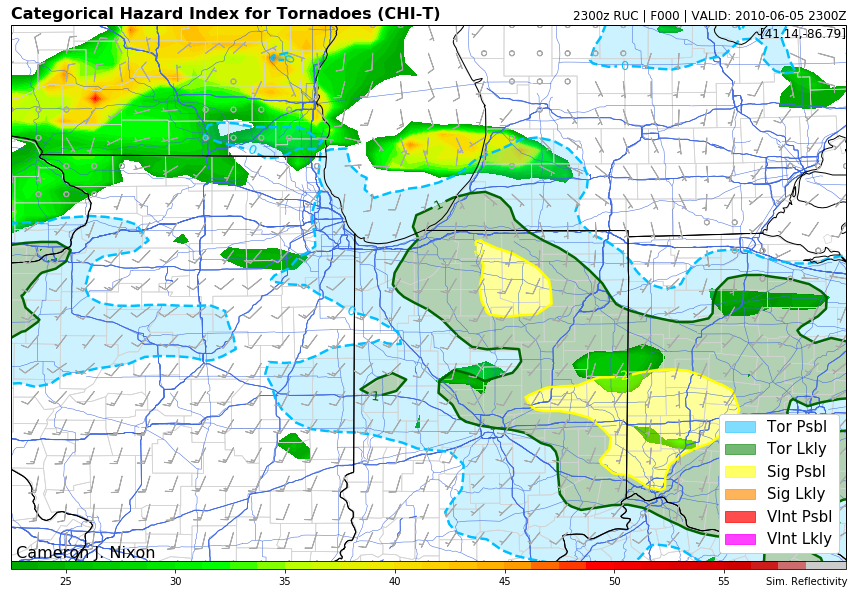

In [2]:
for hours in ('0000','0100','0200','0300','0400'):
    CHI_hourly_RUC('2010', '06', '06', hours, '000', 41.14, -86.79, 'state')